In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

$ vllm serve /home/ubuntu/sky_workdir/examples/.art/models/temporal-clue/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=4096 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=temporal-clue --port=8000 --api-key=default
INFO 03-12 01:31:38 __init__.py:207] Automatically detected platform cuda.
INFO 03-12 01:31:38 api_server.py:912] vLLM API server version 0.7.3
INFO 03-12 01:31:38 api_server.py:913] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/examples/.art/models/temporal-clue/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format=

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:01,  1.51it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.42it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  2.08it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.79it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.75it/s]



INFO 03-12 01:31:49 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-12 01:31:51 worker.py:267] Memory profiling takes 1.09 seconds
INFO 03-12 01:31:51 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 03-12 01:31:51 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 18.75GiB; the rest of the memory reserved for KV Cache is 41.28GiB.
INFO 03-12 01:31:51 executor_base.py:111] # cuda blocks: 10568, # CPU blocks: 20480
INFO 03-12 01:31:51 executor_base.py:116] Maximum concurrency for 16384 tokens per request: 20.64x
INFO 03-12 01:32:33 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 43.15 seconds
INFO 03-12 01:32:33 api_server.py:958] Starting vLLM API server on http://0.0.0.0:8000
INFO 03-12 01:32:33 launcher.py:23] Available routes are:
INFO 03-12 01:32:33 launcher.py:31] Route: /openapi.json, Methods: GE

INFO:     Started server process [144922]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


INFO 03-12 01:32:39 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 03-12 01:32:39 metrics.py:455] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 03-12 01:32:39 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:58870 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

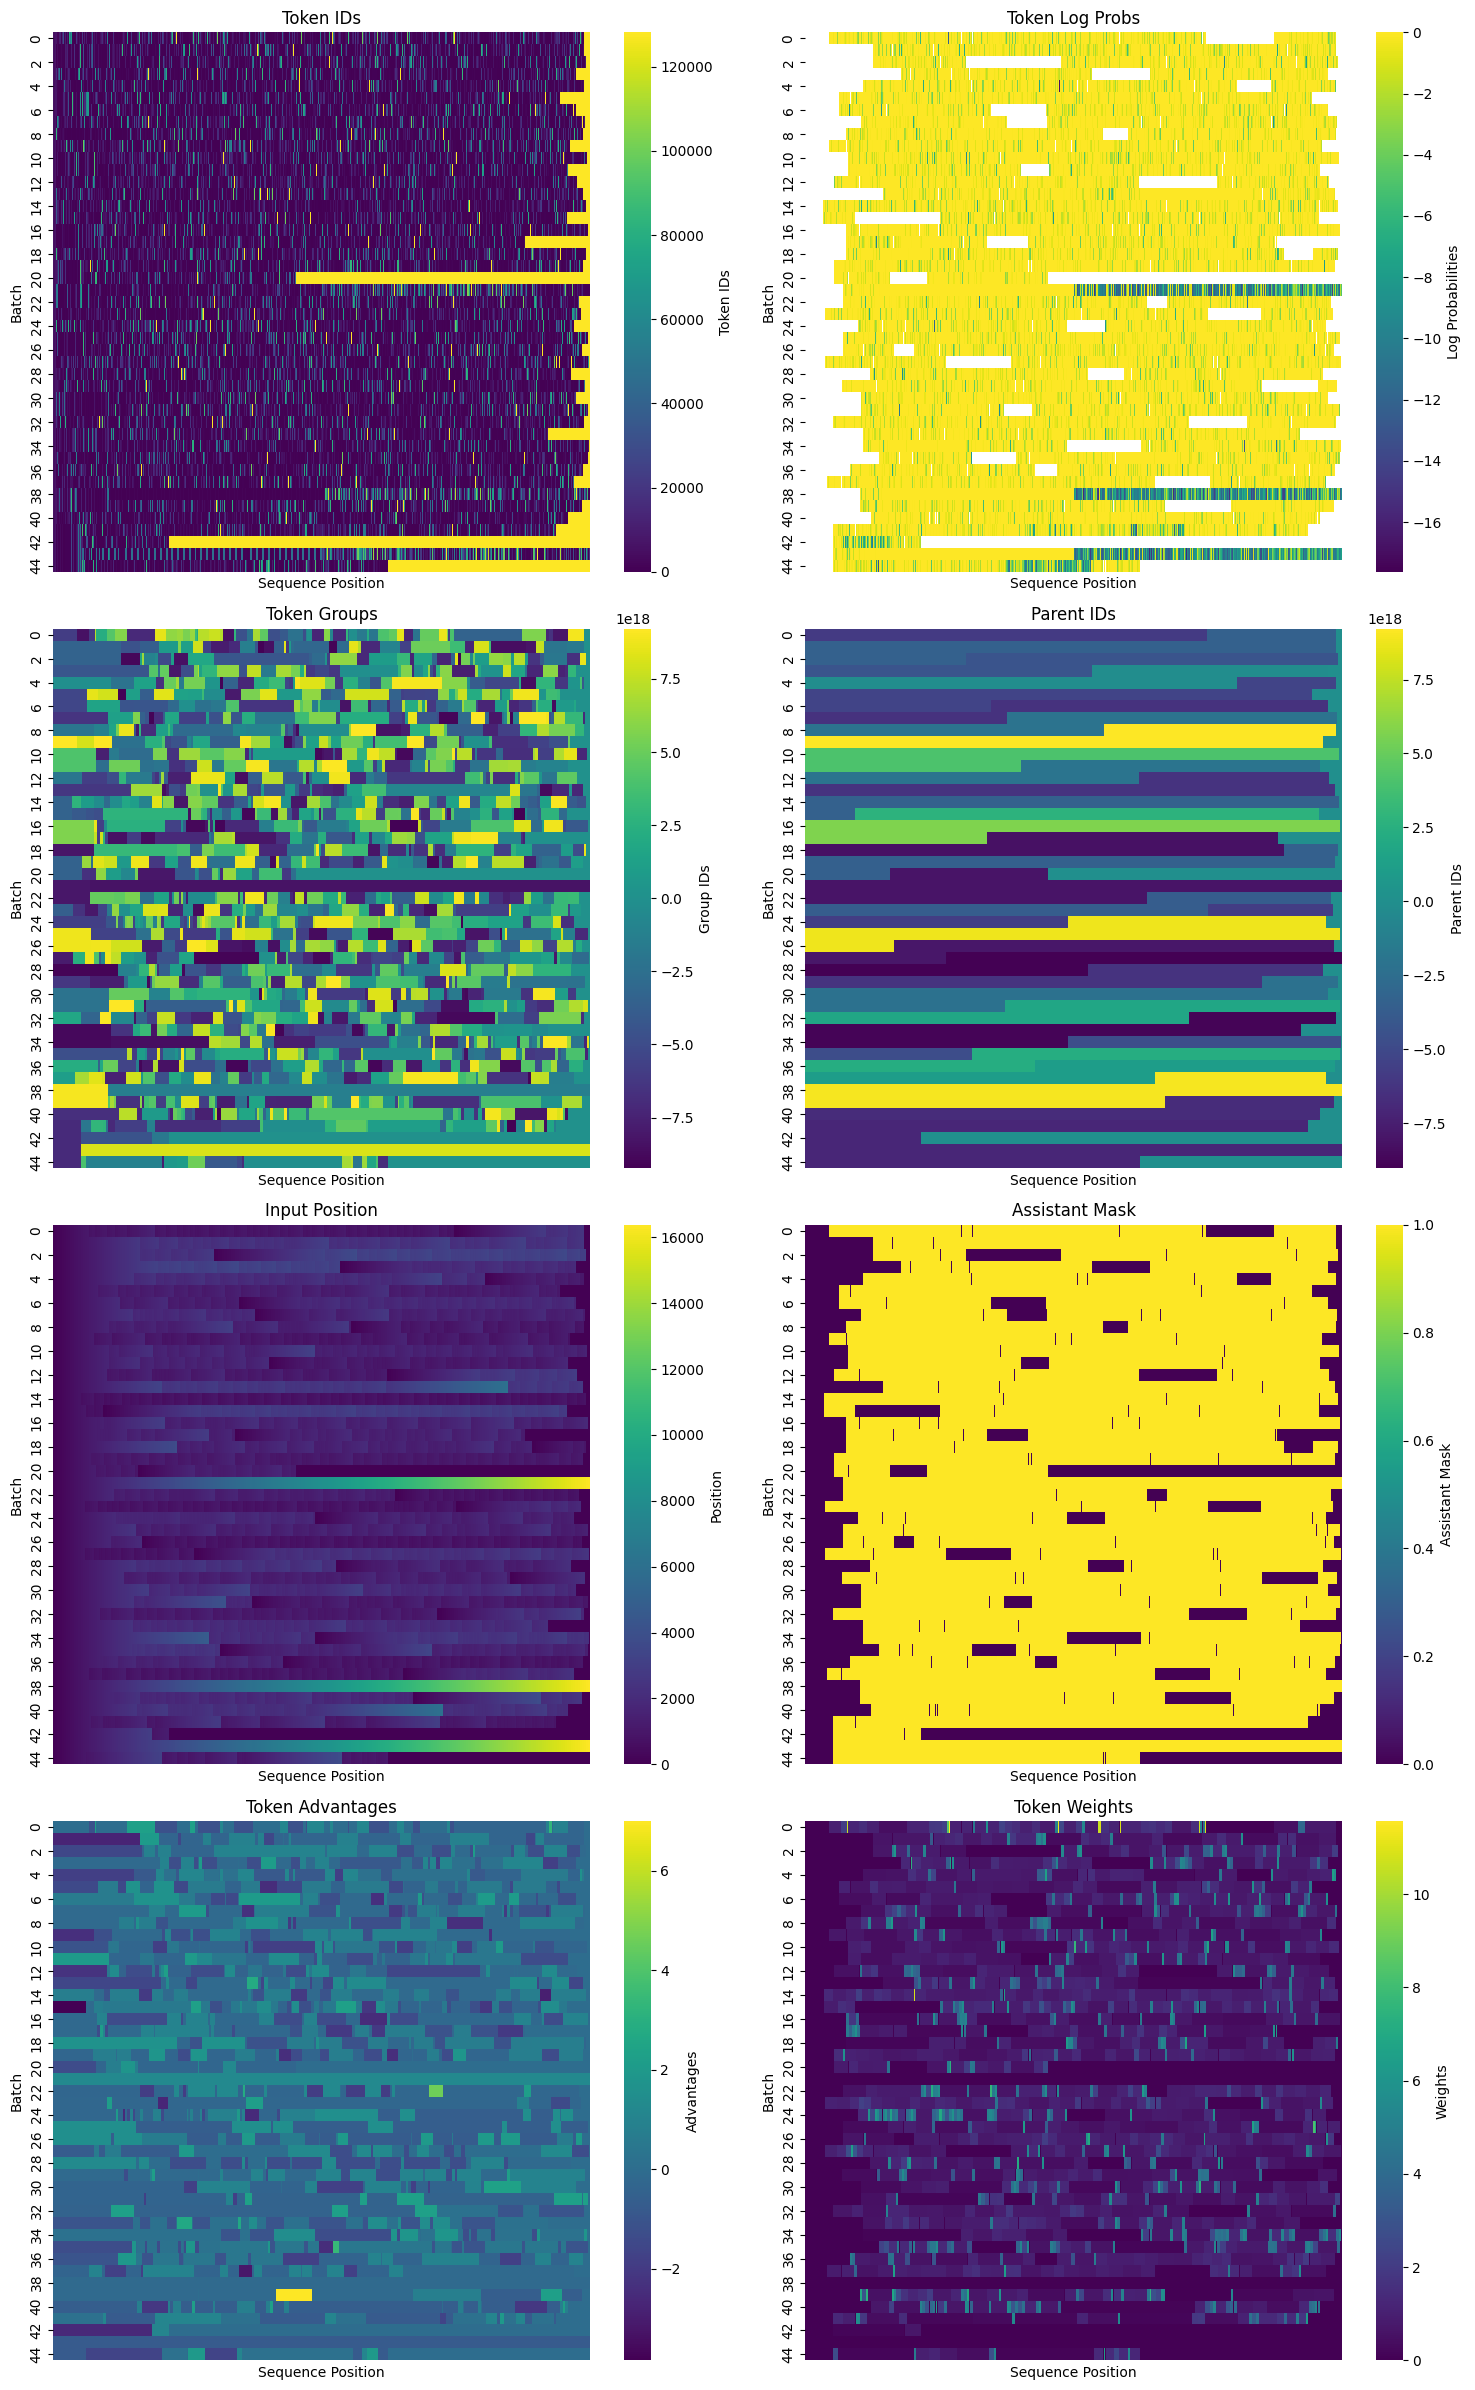

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./.art/models/temporal-clue/config.yaml


  0%|          | 0/45 [00:04<?, ?it/s]


AssertionError: No epoch directory found in output directory ./.art/models/temporal-clue

In [3]:
import art
import asyncio
import json
import openai
import random
import re
from typing import TypedDict


class TemporalCluePuzzle(TypedDict):
    num_clues: int
    prompt: str
    solution: dict[str, str]


puzzles: list[TemporalCluePuzzle] = json.load(open("./data/temporal-clue/puzzles.json"))
val_puzzles = puzzles[:64]
test_puzzles = puzzles[64:128]
train_puzzles = puzzles[128:]
random.seed(42)
random.shuffle(train_puzzles)


api = art.LocalAPI()
model = await api.get_or_create_model(
    name="temporal-clue", base_model="NousResearch/Hermes-2-Theta-Llama-3-8B"
)


async def rollout(
    client: openai.AsyncOpenAI, puzzle: TemporalCluePuzzle
) -> art.Trajectory:
    messages: art.Messages = [{"role": "user", "content": puzzle["prompt"]}]
    chat_completion = await client.chat.completions.create(
        messages=messages, model=model.name
    )
    choice = chat_completion.choices[0]
    messages_and_choices = [*messages, choice]
    content = choice.message.content
    assert isinstance(content, str)
    num_correct = 0
    for key, value in puzzle["solution"].items():
        if matches := re.findall(rf"{key}\. ([A-Za-z \.:-]+)", content):
            match = matches[-1]
            if match.strip().lower() == value.lower():
                num_correct += 1
    reward = acc = num_correct / len(puzzle["solution"])
    return art.Trajectory(
        messages=messages_and_choices, reward=reward, metrics={"acc": acc}
    )


stride = 32
for i in range(await model.get_iteration(), 1_000):
    async with model.openai_client() as openai_client:
        val_groups, train_groups = await asyncio.gather(
            art.gather_groups(
                (
                    (rollout(openai_client, puzzle) for _ in range(2))
                    for puzzle in val_puzzles
                ),
                pbar_desc="val",
            ),
            art.gather_groups(
                (
                    (rollout(openai_client, puzzle) for _ in range(50))
                    for puzzle in train_puzzles[i * stride : (i + 1) * stride]
                ),
                pbar_desc="train",
            ),
        )
    _, _ = await asyncio.gather(
        model.save_eval(val_groups),
        model.tune(train_groups, config=art.TuneConfig(plot_tensors=True)),
    )

  0%|          | 0/46 [20:22<?, ?it/s]


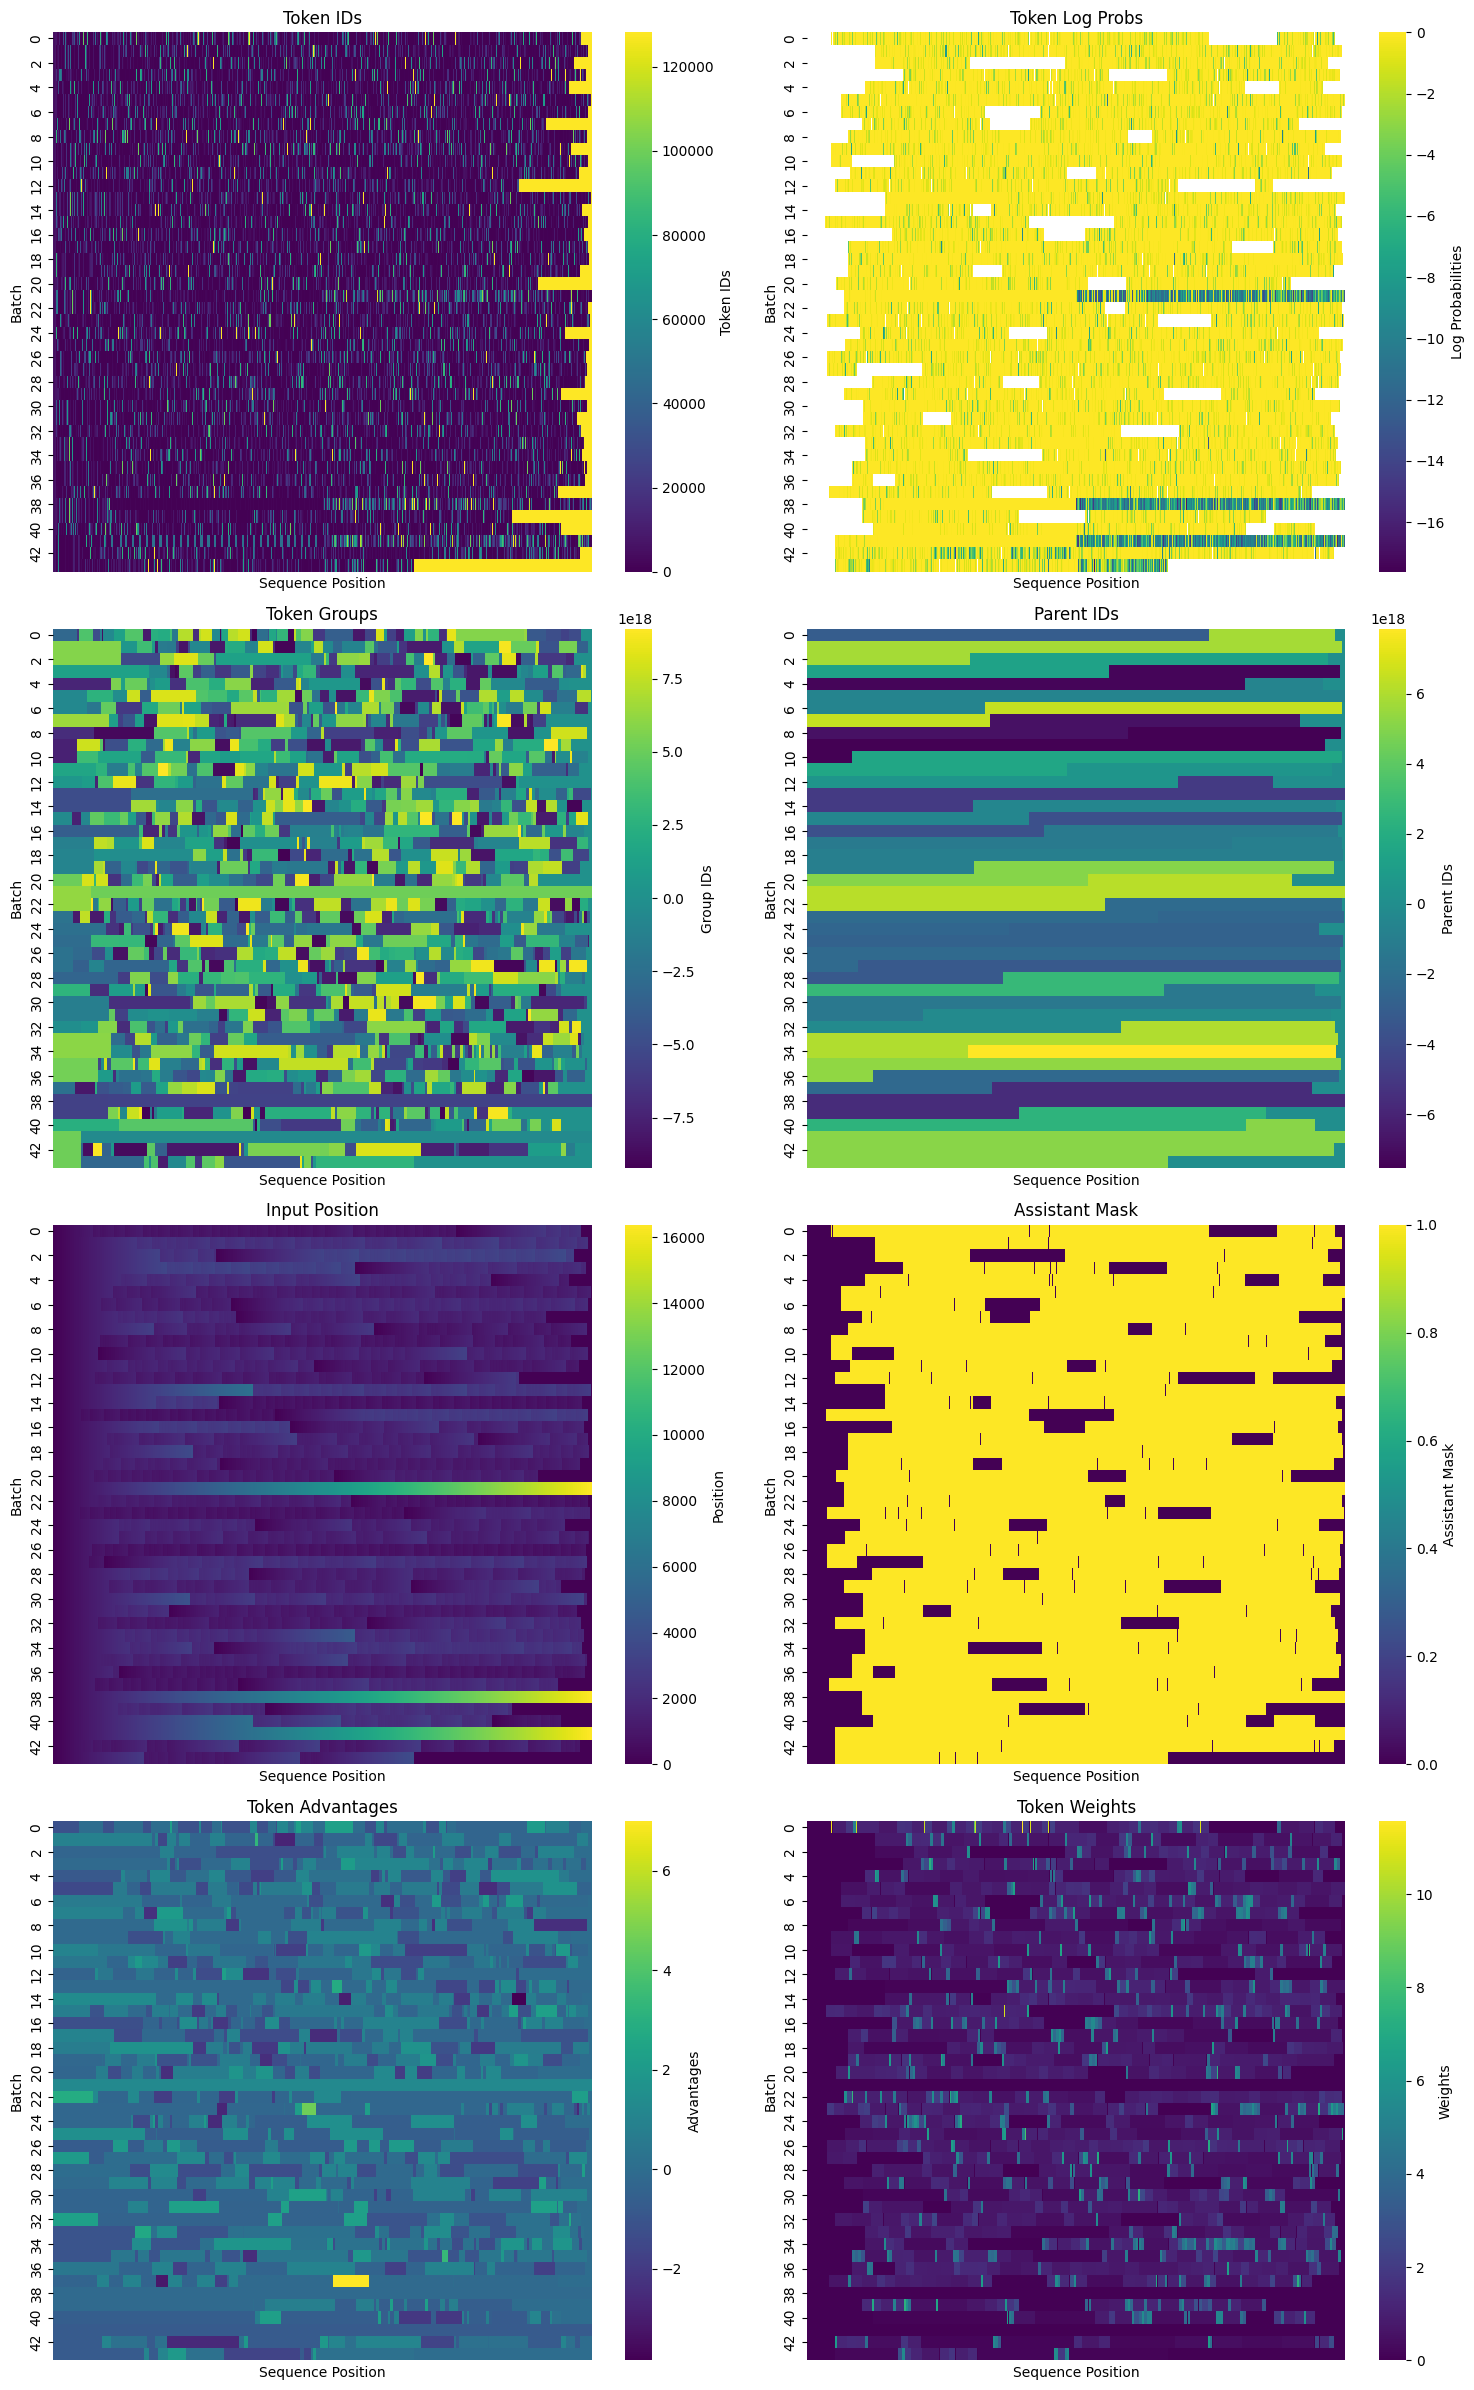

$ tune run art.local.recipe.TuneRecipe --config ./.art/models/temporal-clue/config.yaml


1|21|Loss: 0.0147:  48%|████▊     | 21/44 [05:41<06:14, 16.28s/it, entropy=0.616, loss=0.0843, policy=0.0843]    


In [13]:
await model.tune(train_groups, config=art.TuneConfig(plot_tensors=True))

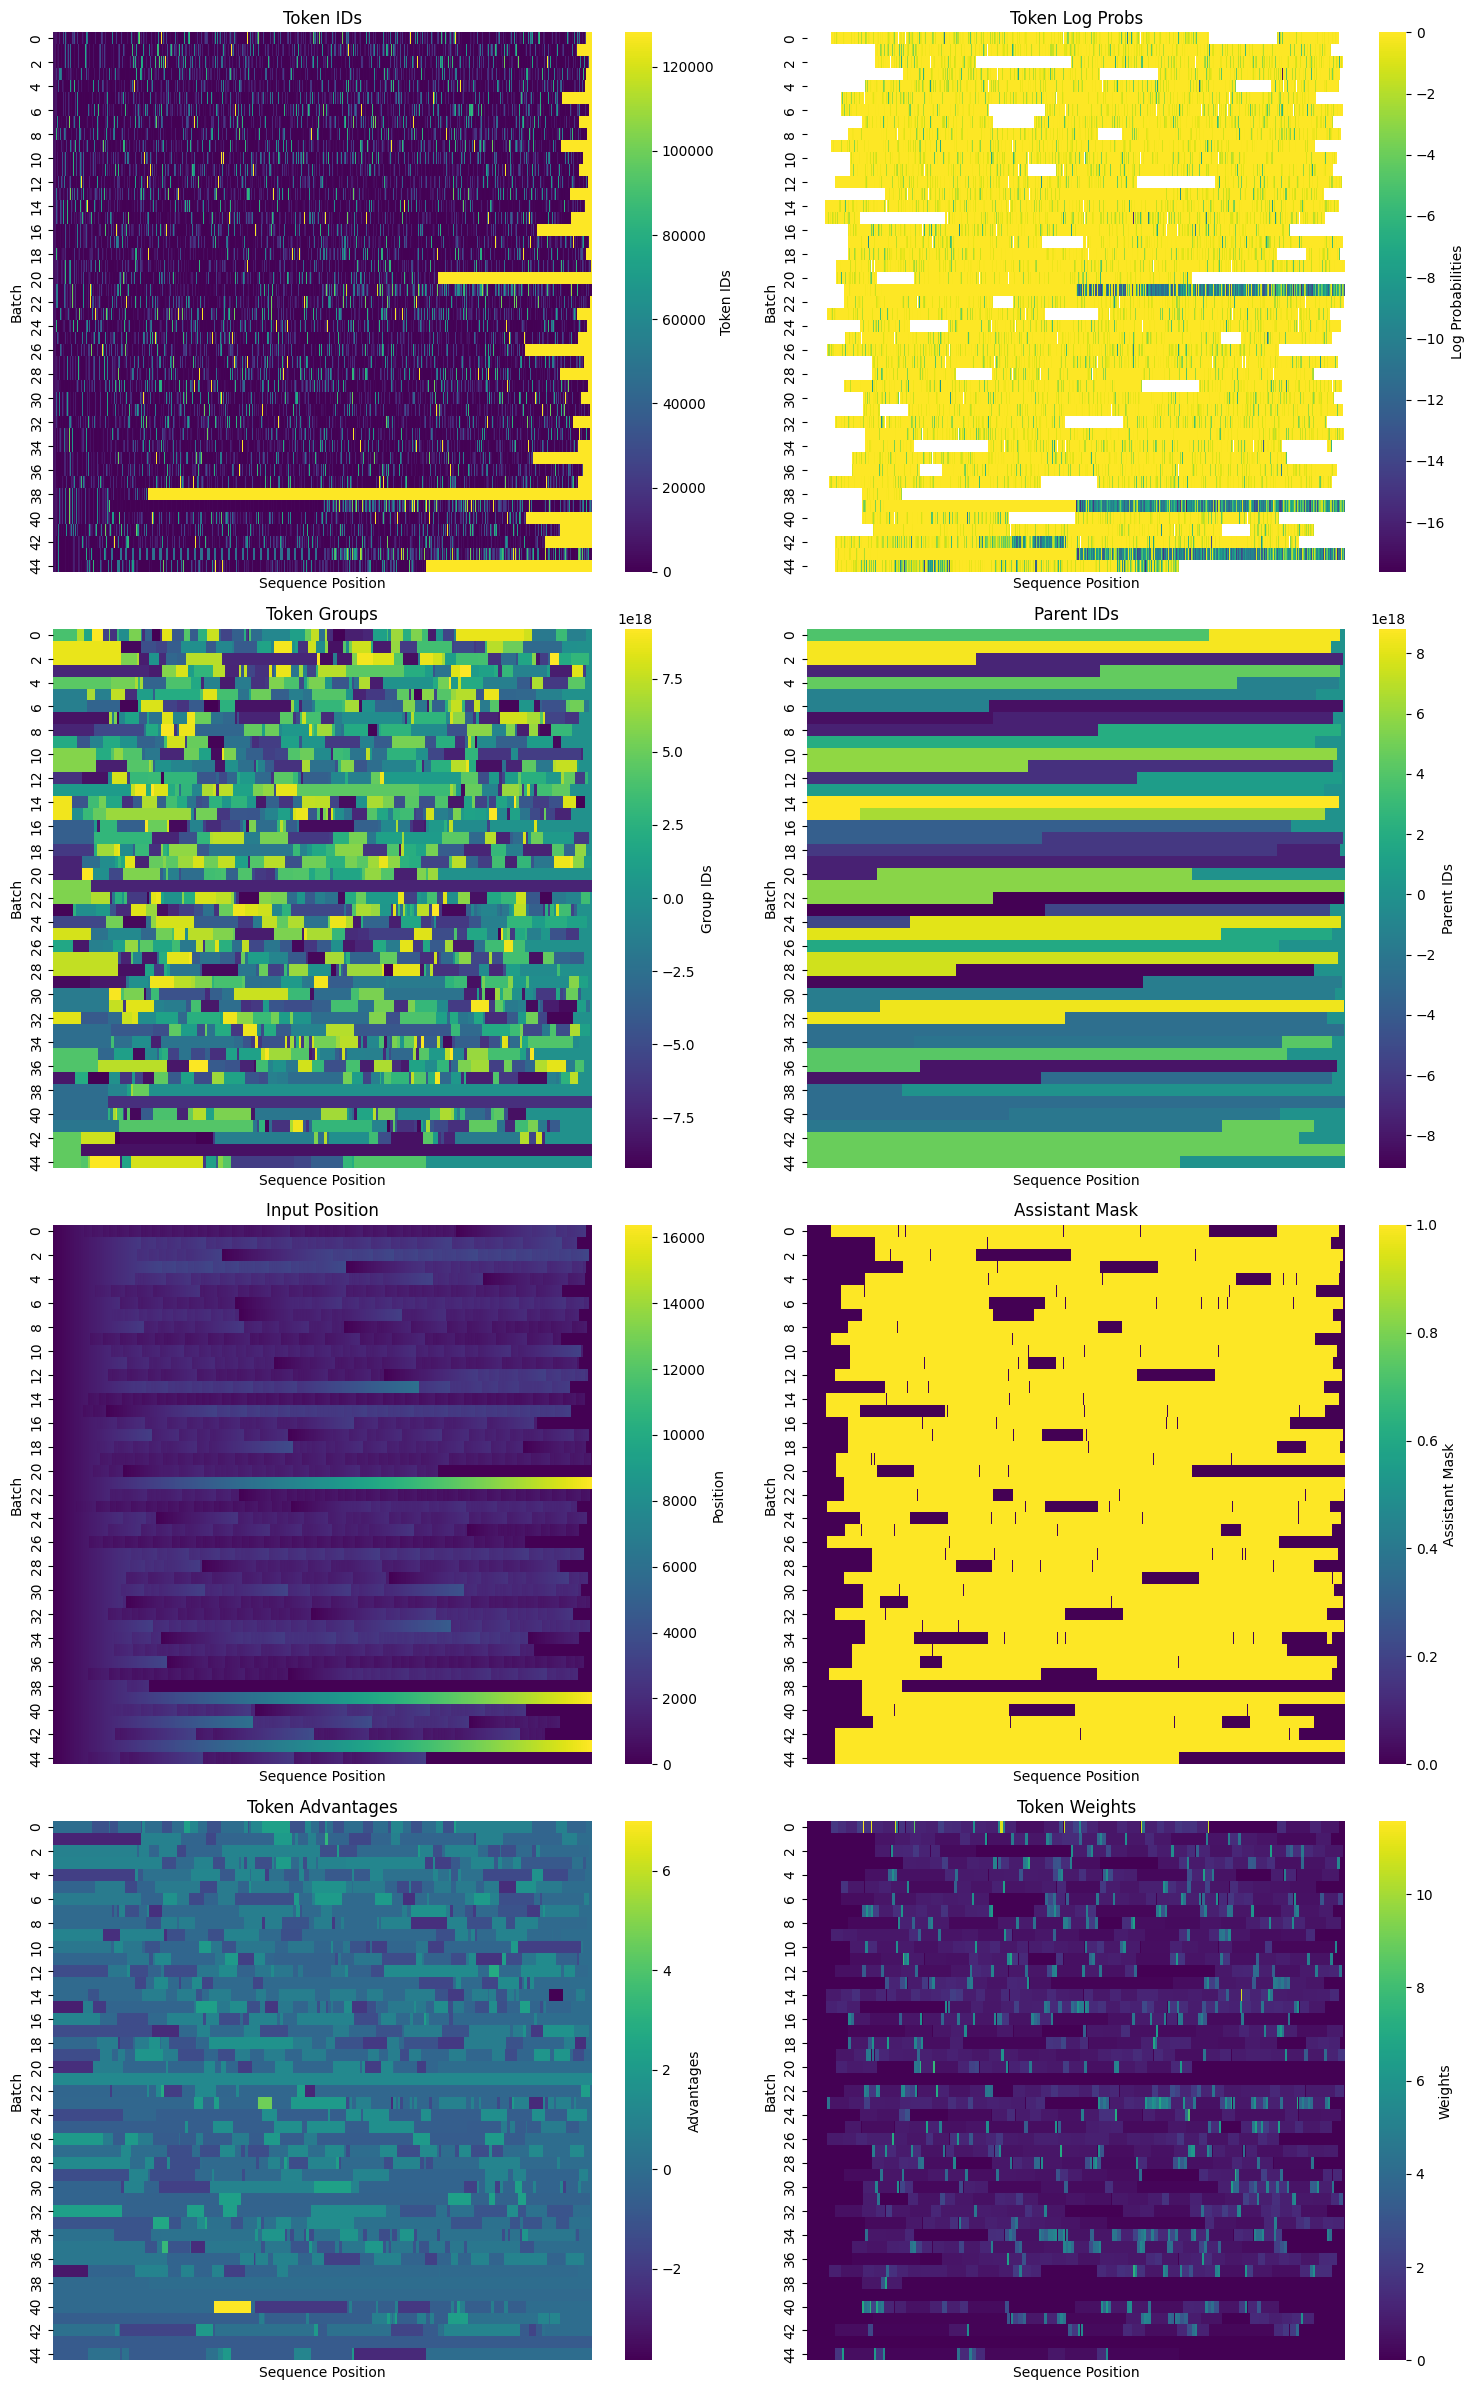

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./.art/models/temporal-clue/config.yaml


  0%|          | 0/45 [00:04<?, ?it/s]


AssertionError: No epoch directory found in output directory ./.art/models/temporal-clue

In [4]:
_, _ = await asyncio.gather(
    model.save_eval(val_groups),
    model.tune(train_groups, config=art.TuneConfig(plot_tensors=True)),
)